In [1]:
# Import
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Concatenate, Flatten, GRU, Dropout
from keras import callbacks
from sklearn.model_selection import KFold
from datetime import datetime
from typing import List


/home/ihar/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Read the data

In [2]:
data = pd.read_csv('data.csv', sep=',')

# Show distribution of activities per user

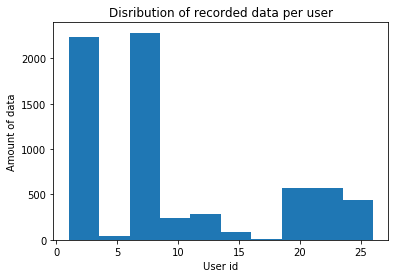

In [3]:
plt.hist(data.user)
plt.title('Disribution of recorded data per user')
plt.ylabel('Amount of data')
plt.xlabel('User id')
plt.show()

# Data preprocessing

In [4]:
words = [] # Array of unique words
apps = [] # Array of uniques apps
users = [] # Array of unique users

def check_app(name: str) -> str:
    """
    Remove unnecessary informartion from an application name
    :param name: a name of an application
    :return: a formated name
    """
    
    # Remove backslahes
    if '\\' in name:
        return name.split('\\')[-1]
    elif '/' in name:
        return name.split('/')[-1]
    return name
            
for name in data.window_title:
    for word in name.split():
        if word.lower() not in words:
            words.append(word.lower())
            
for name in data.app:
    l_name = check_app(name)
    if l_name.lower() not in apps:
        apps.append(l_name.lower())
            
for name in data.user:
    if name not in users:
        users.append(name)

In [5]:
words_to_index = {} # Mapping from a word to a unique number representing that word
index_to_words = {} # Reverse mapping


for k, v in enumerate(words):
    index_to_words[k] = v
    words_to_index[v] = k

apps_to_index = {} # Mapping from an app name to a unique number representing that app
index_to_apps = {} # Reverse mapping


for k, v in enumerate(apps):
    index_to_apps[k] = v
    apps_to_index[v] = k
    
users_to_index = {} # Mapping from a user id to a unique number representing that user
index_to_users = {} # Reverse mapping


for k, v in enumerate(users):
    index_to_users[k] = v
    users_to_index[v] = k

In [6]:
temp_data = [[] for i in users] # an array to accommodate data before converting it to time dependent windows

def words_to_vec(seq_words: str) -> List:
    """
    One hot encoding of words
    :param: seq_words: a sequnce of words to be encoded
    :return: a vector representation of that sequence
    """
    vec = np.zeros(len(words))
    for word in seq_words.split():
        vec[words_to_index[word.lower()]] += 1
    return vec
        
def app_to_vec(app: str) -> List:
    """
    One hot encoding of an application
    :param: seq_words: a name of an app
    :return: a vector representation of that app
    """
    vec = np.zeros(len(apps))
    vec[apps_to_index[check_app(app.lower())]] += 1
    return vec
        
def convert_str_to_time(time_str: str) -> datetime:
    """
    Convert string representation of time to datetime
    :param: time_str: a string representation of time
    :return: a datetime
    """
    tmp = time_str.replace(' ', 't').split('+')[0]
    if not '.' in tmp:
        tmp = tmp + '.0'
    return datetime.strptime(tmp, '%Y-%m-%dt%H:%M:%S.%f')
    
def get_duration(start_time: str, end_time: str) -> float:
    """
    Get activity duration from start and end times
    :param: start_time: a string representing a start time of an activity
    :param: end_time: a string representing an end time of the activity
    :return: a duration of the activity in seconds
    """
    start = convert_str_to_time(start_time)
    end = convert_str_to_time(end_time)
    return abs((end - start).total_seconds())

# Transform all data and put in the temp array
for i in range(len(data.user)):
    user = users_to_index[data.user[i]]
    temp_data[user].append([app_to_vec(data.app[i]), get_duration(data.start_date[i], data.end_date[i]),
                            words_to_vec(data.window_title[i])])
   


# Distribution of duration time

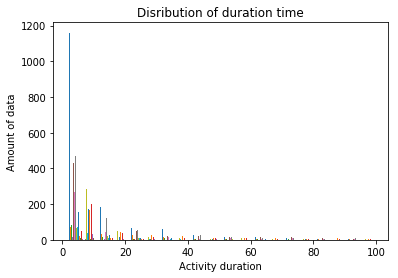

In [7]:
duration = []
for user in range (len(users)):
    duration.append([])
    for j in temp_data[user]:
        duration[-1].append(j[1])
        
plt.hist(duration, range=(1, 100))
plt.title('Disribution of duration time')
plt.ylabel('Amount of data')
plt.xlabel('Activity duration')
plt.show()

In [8]:
def generate_data(sequence_len: int, num_of_features: int = 1, target_to_categorical: bool = True):
    """
    Group the data to a series of activities
    :param: sequence_len: a length of sequences to be generated
    :param: num_of_features: a number of features to use
    :param: transform target values to a vector or not
    """
    X = [[], [], [], []]
    Y = []

    for user in range(len(users)):
        for i in range(sequence_len, len(temp_data[user])):
            for j in range(num_of_features):
                X[j].append(np.array([np.array(temp_data[user][k][j]) for k in range(i - sequence_len, i)]))
            tmp = np.zeros(len(users))
            tmp[user] = 1
            Y.append(tmp) if target_to_categorical else Y.append(user)
            for j in range(num_of_features, 3):
                X[j].append([0 for k in range(sequence_len)])
                
    X[0], X[1], X[2], Y = shuffle(X[0], X[1], X[2], Y, random_state=0)

    X[0] = np.array(X[0])
    X[1] = np.array(X[1]).reshape(-1, sequence_len, 1)
    X[2] = np.array(X[2])
    Y = np.array(Y)

    return X, Y

# Create a model

In [33]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


In [10]:
from keras.utils import plot_model

def create_model_app():
    """
    A model only using information about a set of apps a person used
    """
    input_app = Input(shape=(None, len(apps)), name='Appication')
    app_LSTM = LSTM(50, recurrent_dropout=0.1)(input_app)

    dense = Dropout(0.3)(Dense(150 ,activation='relu', name='Dense_1')(app_LSTM))
    dense = Dropout(0.3)(Dense(100 ,activation='relu', name='Dense_2')(dense))
    dense = Dropout(0.3)(Dense(100 ,activation='relu', name='Dense_3')(dense))
    output =  Dense((len(users)), activation='softmax', name='Dense_4')(dense)
    model = Model(inputs=[input_app],outputs=[output])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', f1_score])
    plot_model(model, to_file='model.png', show_layer_names=False, show_shapes=True)
    
    return model

def create_model_app_duration():
    """
    A model using information about a set of apps a person used and a duration of an activity
    """
    input_app = Input(shape=(None, len(apps)), name='Appication')
    input_duration = Input(shape=(None,1), name='Duration')
    app_LSTM = LSTM(50, recurrent_dropout=0.1)(input_app)
    duration_LSTM = LSTM(50, recurrent_dropout=0.1)(input_duration)
    concat = Concatenate(name='Concatenate')([app_LSTM, duration_LSTM])

    dense = Dropout(0.3)(Dense(150 ,activation='relu', name='Dense_1')(concat))
    dense = Dropout(0.3)(Dense(100 ,activation='relu', name='Dense_2')(dense))
    dense = Dropout(0.3)(Dense(100 ,activation='relu', name='Dense_3')(dense))
    output =  Dense((len(users)), activation='softmax', name='Dense_4')(dense)
    model = Model(inputs=[input_app, input_duration],outputs=[output])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', f1_score])
    plot_model(model, to_file='model_duration.png', show_layer_names=False, show_shapes=True)

    return model

def create_model_app_duration_words():
    """
    A model using information about a set of apps a person used, a duration of an activity
    and a set of words he used for web search
    """
    input_words = Input(shape=(None,len(words)), name='Set_of_words')
    input_app = Input(shape=(None, len(apps)), name='Appication')
    input_duration = Input(shape=(None,1), name='Duration')
    words_LSTM = LSTM(50, recurrent_dropout=0.1)(input_words)
    app_LSTM = LSTM(50, recurrent_dropout=0.1)(input_app)
    duration_LSTM = LSTM(50, recurrent_dropout=0.1)(input_duration)
    concat = Concatenate(name='Concatenate')([app_LSTM, duration_LSTM, words_LSTM])

    dense = Dropout(0.3)(Dense(150 ,activation='relu', name='Dense_1')(concat))
    dense = Dropout(0.3)(Dense(100 ,activation='relu', name='Dense_2')(dense))
    dense = Dropout(0.3)(Dense(100 ,activation='relu', name='Dense_3')(dense))
    output =  Dense((len(users)), activation='softmax', name='Dense_4')(dense)
    model = Model(inputs=[input_app, input_duration, input_words],outputs=[output])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', f1_score])
    plot_model(model, to_file='model_duration.png', show_layer_names=False, show_shapes=True)
    
    return model

# Test a model with different sequence lengths and features

In [11]:
# Train a model with information about apps
history_app = []
history_app_duration = []
history_app_duration_words = []

for seq_len in range(1, 11):
    X, Y = generate_data(sequence_len=seq_len)

    model = create_model_app()

    history_app.append(model.fit(x=[X[0]], 
          y=Y,
          batch_size=64,
          epochs=70,
          validation_split=0.1,
          verbose=0,
          callbacks=[callbacks.ModelCheckpoint('model_app.h5py', save_best_only=True)]))
    
    X, Y = generate_data(sequence_len=seq_len, num_of_features=2)

    model = create_model_app_duration()
    history_app_duration.append(model.fit(x=[X[0], X[1].reshape(-1, seq_len, 1)], 
          y=Y,
          batch_size=64,
          epochs=70,
          validation_split=0.1,
          verbose=0,
          callbacks=[callbacks.ModelCheckpoint('model_app_duration.h5py', save_best_only=True)]))
    
    X, Y = generate_data(sequence_len=seq_len, num_of_features=3)

    model = create_model_app_duration_words()

    history_app_duration_words.append(model.fit(x=[X[0], X[1].reshape(-1, seq_len, 1), X[2]], 
          y=Y,
          batch_size=64,
          epochs=70,
          validation_split=0.1,
          verbose=0,
          callbacks=[callbacks.ModelCheckpoint('model_app_duration_words.h5py', save_best_only=True)]))

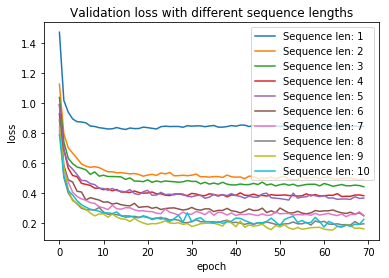

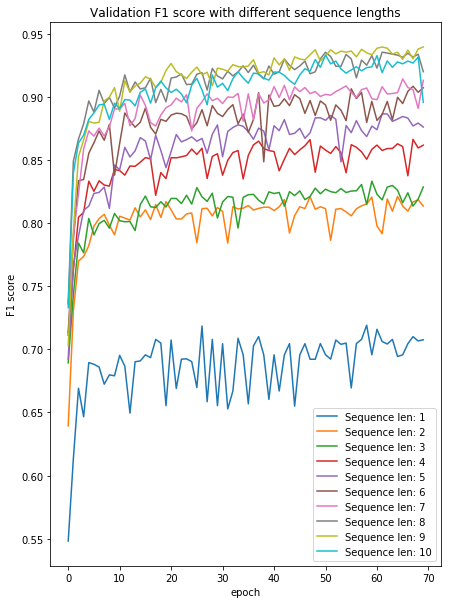

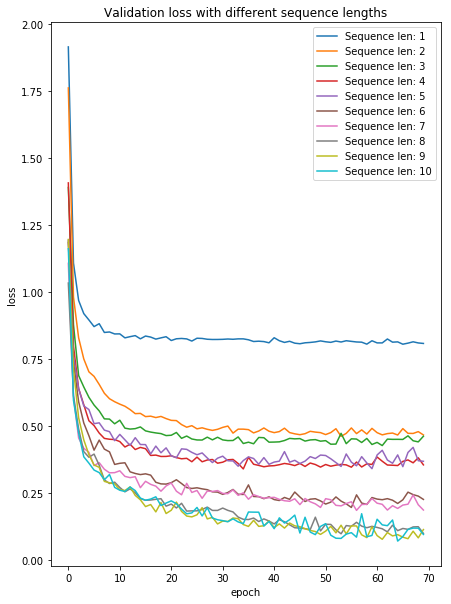

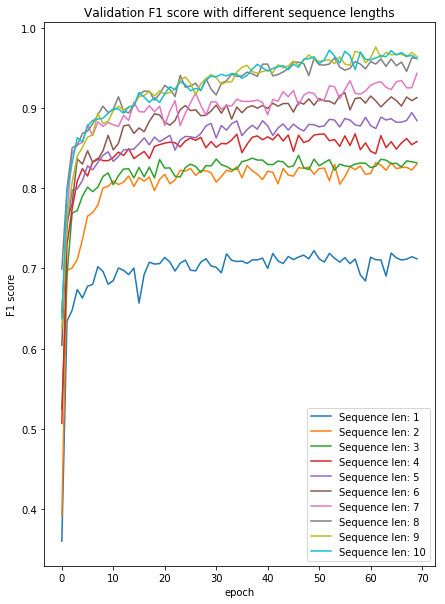

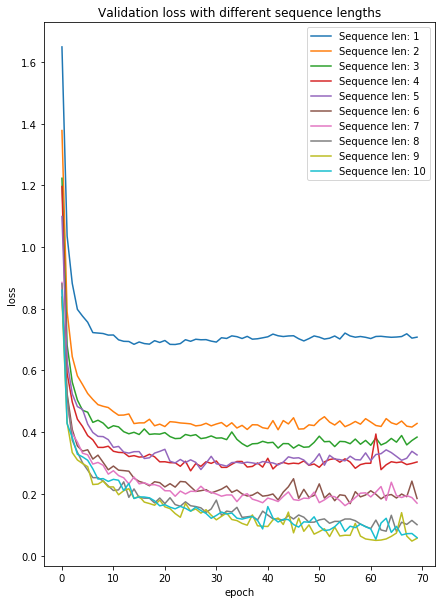

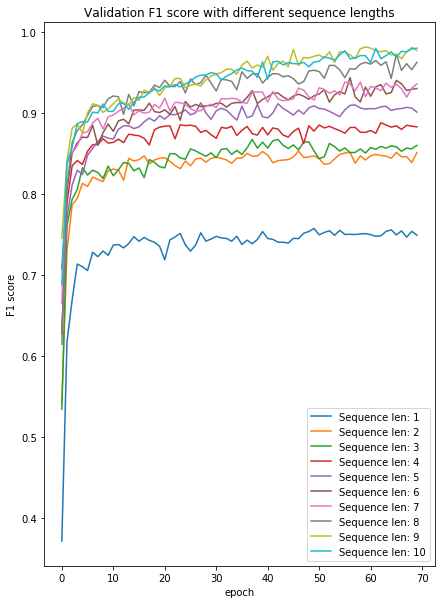

In [12]:
for history in [history_app, history_app_duration, history_app_duration_words]:
    # Build a plot showing validation scores for loss
    for h in history:
        plt.plot(h.history['val_loss'])
    plt.title('Validation loss with different sequence lengths')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Sequence len: ' + str(i + 1) for i in range(len(history))], loc='upper right')
    plt.rcParams["figure.figsize"] = [7, 10]
    plt.show()

    # Build a plot showing validation scores for f1
    for h in history:
        plt.plot(h.history['val_f1_score'])
    plt.title('Validation F1 score with different sequence lengths')
    plt.ylabel('F1 score')
    plt.xlabel('epoch')
    plt.legend(['Sequence len: ' + str(i + 1) for i in range(len(history))], loc='lower right')
    plt.rcParams["figure.figsize"] = [7, 10]
    plt.show()

One can see from the previous graphics that models showed almolst the same performance when sequence length was equal to 8, 9 or 10. So we will test all types of models via 10-fold cross validation with that sequence length

In [13]:
from keras import callbacks

# Perform 10-fold cross validation to compare selected models
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = [[], [], []]
X, Y = generate_data(sequence_len=8, num_of_features=1)
for train, test in kfold.split(Y):
  
    model = create_model_app()

    model.fit(x=[X[0][train]], 
          y=Y[train],
          batch_size=64,
          epochs=100,
          validation_split=0.1,
          verbose=0,
          callbacks=[callbacks.ModelCheckpoint('model_app.h5py', save_best_only=True)])
    model.load_weights(filepath='model_app.h5py')
    scores = model.evaluate([X[0][test]], Y[test], verbose=0)
    
    for i in range(len(scores)):
        print("%s: %.2f" % (model.metrics_names[i], scores[i]))
        cvscores[i].append(scores[i])

loss: 0.21
acc: 0.91
f1_score: 0.92
loss: 0.18
acc: 0.93
f1_score: 0.94
loss: 0.19
acc: 0.93
f1_score: 0.93
loss: 0.17
acc: 0.94
f1_score: 0.94
loss: 0.18
acc: 0.93
f1_score: 0.93
loss: 0.20
acc: 0.93
f1_score: 0.93
loss: 0.24
acc: 0.91
f1_score: 0.91
loss: 0.16
acc: 0.94
f1_score: 0.94
loss: 0.17
acc: 0.94
f1_score: 0.94
loss: 0.19
acc: 0.92
f1_score: 0.93


### Results for model using information about apps

In [14]:
for i in range(len(scores)):
    print(model.metrics_names[i] + ": %.4f (+/- %.4f)" % (np.mean(cvscores[i]), np.std(cvscores[i])))

loss: 0.1879 (+/- 0.0238)
acc: 0.9291 (+/- 0.0106)
f1_score: 0.9304 (+/- 0.0098)


In [15]:
from keras import callbacks

# Perform 10-fold cross validation to compare selected models
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = [[], [], []]
X, Y = generate_data(sequence_len=8, num_of_features=2)
for train, test in kfold.split(Y):
  
    model = create_model_app_duration()

    model.fit(x=[X[0][train], X[1][train]], 
          y=Y[train],
          batch_size=64,
          epochs=100,
          validation_split=0.1,
          verbose=0,
          callbacks=[callbacks.ModelCheckpoint('model_app_duration.h5py', save_best_only=True)])
    model.load_weights(filepath='model_app_duration.h5py')
    scores = model.evaluate([X[0][test],  X[1][test]], Y[test], verbose=0)
    
    for i in range(len(scores)):
        print("%s: %.2f" % (model.metrics_names[i], scores[i]))
        cvscores[i].append(scores[i])

loss: 0.16
acc: 0.95
f1_score: 0.95
loss: 0.15
acc: 0.95
f1_score: 0.95
loss: 0.11
acc: 0.96
f1_score: 0.96
loss: 0.14
acc: 0.95
f1_score: 0.95
loss: 0.12
acc: 0.97
f1_score: 0.97
loss: 0.13
acc: 0.96
f1_score: 0.96
loss: 0.13
acc: 0.97
f1_score: 0.97
loss: 0.11
acc: 0.96
f1_score: 0.96
loss: 0.09
acc: 0.97
f1_score: 0.97
loss: 0.11
acc: 0.96
f1_score: 0.96


### Results for model using information about apps and duration of activity

In [16]:
for i in range(len(scores)):
    print(model.metrics_names[i] + ": %.4f (+/- %.4f)" % (np.mean(cvscores[i]), np.std(cvscores[i])))

loss: 0.1263 (+/- 0.0188)
acc: 0.9592 (+/- 0.0080)
f1_score: 0.9591 (+/- 0.0081)


In [18]:
from keras import callbacks

# Perform 10-fold cross validation to compare selected models
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = [[], [], []]
X, Y = generate_data(sequence_len=8, num_of_features=3)
for train, test in kfold.split(Y):
  
    model = create_model_app_duration_words()

    model.fit(x=[X[0][train], X[1][train], X[2][train]], 
          y=Y[train],
          batch_size=64,
          epochs=100,
          validation_split=0.1,
          verbose=0,
          callbacks=[callbacks.ModelCheckpoint('model_app_duration_words.h5py', save_best_only=True)])
    model.load_weights(filepath='model_app_duration_words.h5py')
    scores = model.evaluate([X[0][test],  X[1][test], X[2][test]], Y[test], verbose=0)
    
    for i in range(len(scores)):
        print("%s: %.2f" % (model.metrics_names[i], scores[i]))
        cvscores[i].append(scores[i])

loss: 0.16
acc: 0.96
f1_score: 0.96
loss: 0.09
acc: 0.97
f1_score: 0.97
loss: 0.09
acc: 0.97
f1_score: 0.97
loss: 0.08
acc: 0.98
f1_score: 0.98
loss: 0.15
acc: 0.96
f1_score: 0.96
loss: 0.06
acc: 0.97
f1_score: 0.97
loss: 0.15
acc: 0.97
f1_score: 0.97
loss: 0.09
acc: 0.96
f1_score: 0.96
loss: 0.11
acc: 0.97
f1_score: 0.97
loss: 0.13
acc: 0.96
f1_score: 0.96


### Results for model using information about apps, duration of activity and a set of words

In [19]:
for i in range(len(scores)):
    print(model.metrics_names[i] + ": %.4f (+/- %.4f)" % (np.mean(cvscores[i]), np.std(cvscores[i])))

loss: 0.1112 (+/- 0.0326)
acc: 0.9681 (+/- 0.0065)
f1_score: 0.9680 (+/- 0.0064)


# Compare model with SVM, KNN and NN

# NN

In [34]:
def create_model_nn():
    """
    A model only using information about a set of apps a person used
    """
    input_app = Input(shape=(8, len(apps)), name='Appication')

    dense = Dropout(0.3)(Dense(150 ,activation='relu', name='Dense_1')(Flatten()(input_app)))
    dense = Dropout(0.3)(Dense(100 ,activation='relu', name='Dense_2')(dense))
    dense = Dropout(0.3)(Dense(100 ,activation='relu', name='Dense_3')(dense))
    output =  Dense((len(users)), activation='softmax', name='Dense_4')(dense)
    model = Model(inputs=[input_app],outputs=[output])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', f1_score])
    
    return model

In [35]:
from keras import callbacks

# Perform 10-fold cross validation to compare selected models
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = [[], [], []]
X, Y = generate_data(sequence_len=8, num_of_features=1)
for train, test in kfold.split(Y):
  
    model = create_model_nn()

    model.fit(x=[X[0][train]], 
          y=Y[train],
          batch_size=64,
          epochs=100,
          validation_split=0.1,
          verbose=0,
          callbacks=[callbacks.ModelCheckpoint('model_nn.h5py', save_best_only=True)])
    model.load_weights(filepath='model_nn.h5py')
    scores = model.evaluate([X[0][test]], Y[test], verbose=0)
    
    for i in range(len(scores)):
        print("%s: %.2f" % (model.metrics_names[i], scores[i]))
        cvscores[i].append(scores[i])

loss: 0.35
acc: 0.86
f1_score: 0.86
loss: 0.35
acc: 0.88
f1_score: 0.88
loss: 0.34
acc: 0.88
f1_score: 0.87
loss: 0.28
acc: 0.91
f1_score: 0.91
loss: 0.29
acc: 0.89
f1_score: 0.89
loss: 0.33
acc: 0.89
f1_score: 0.89
loss: 0.35
acc: 0.87
f1_score: 0.87
loss: 0.28
acc: 0.90
f1_score: 0.90
loss: 0.28
acc: 0.90
f1_score: 0.90
loss: 0.36
acc: 0.88
f1_score: 0.88


### Results for NN model using information about apps

In [36]:
for i in range(len(scores)):
    print(model.metrics_names[i] + ": %.4f (+/- %.4f)" % (np.mean(cvscores[i]), np.std(cvscores[i])))

loss: 0.3199 (+/- 0.0334)
acc: 0.8852 (+/- 0.0147)
f1_score: 0.8853 (+/- 0.0146)


In [73]:
from sklearn.metrics import f1_score, log_loss, accuracy_score
from sklearn.svm import SVC

# Perform 10-fold cross validation to compare selected models
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = [[], [], []]
metrics = ['loss', 'acc', 'f1_score']
metrics_func = [log_loss, accuracy_score, f1_score]


def predict_proba_ordered(probs: List, classes_: List, all_classes: List):
    """
    Add missing classes to probabilities
    
    :param: probs: list of probabilities, output of predict_proba 
    :param: classes_: clf.classes_
    :param: all_classes: all possible classes (superset of classes_)
    :return: an array containt all probabilities
    """
    proba_ordered = np.zeros((probs.shape[0], all_classes.size),  dtype=np.float)
    sorter = np.argsort(all_classes)
    idx = sorter[np.searchsorted(all_classes, classes_, sorter=sorter)]
    proba_ordered[:, idx] = probs
    return proba_ordered


X, Y = generate_data(sequence_len=8, num_of_features=1, target_to_categorical=False)
all_classes = np.array([k for k in range(len(users))])

for train, test in kfold.split(Y):
    
    model = SVC(kernel='linear',probability=True)
    model.fit(X[0][train].reshape(-1, X[0].shape[1] * X[0].shape[2]), Y[train])
    y_pred = model.predict_proba(X[0][test].reshape(-1, X[0].shape[1] * X[0].shape[2]))
    y_pred_prob = predict_proba_ordered(y_pred, model.classes_, all_classes)
    y_pred = model.predict(X[0][test].reshape(-1, X[0].shape[1] * X[0].shape[2]))
    
    for i in range(len(metrics)):
        if i == 0:
            score = metrics_func[i](Y[test], y_pred_prob, labels=all_classes)
        elif i == 1:
            score = metrics_func[i](Y[test], y_pred)
        else:
            score = metrics_func[i](Y[test], y_pred, average='weighted')
        print("%s: %.4f" % (metrics[i], score))
        cvscores[i].append(score)

loss: 0.4386
acc: 0.8435
f1_score: 0.8340


/home/ihar/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


loss: 0.4046
acc: 0.8571
f1_score: 0.8504
loss: 0.3912
acc: 0.8647
f1_score: 0.8535


/home/ihar/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


loss: 0.3334
acc: 0.9012
f1_score: 0.8937
loss: 0.3795
acc: 0.8602
f1_score: 0.8498
loss: 0.4092
acc: 0.8539
f1_score: 0.8449
loss: 0.4204
acc: 0.8508
f1_score: 0.8406
loss: 0.3620
acc: 0.8721
f1_score: 0.8659
loss: 0.3573
acc: 0.8782
f1_score: 0.8707
loss: 0.3788
acc: 0.8798
f1_score: 0.8675


### Results for SVM model using information about apps

In [75]:
for i in range(len(cvscores)):
    print(metrics[i] + ": %.4f (+/- %.4f)" % (np.mean(cvscores[i]), np.std(cvscores[i])))

loss: 0.3875 (+/- 0.0302)
acc: 0.8662 (+/- 0.0162)
f1_score: 0.8571 (+/- 0.0167)


In [88]:
from sklearn.neighbors import KNeighborsClassifier

# Perform 10-fold cross validation to compare selected models
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = [[], []]
metrics = ['acc', 'f1_score']
metrics_func = [accuracy_score, f1_score]


def predict_proba_ordered(probs: List, classes_: List, all_classes: List):
    """
    Add missing classes to probabilities
    
    :param: probs: list of probabilities, output of predict_proba 
    :param: classes_: clf.classes_
    :param: all_classes: all possible classes (superset of classes_)
    :return: an array containt all probabilities
    """
    proba_ordered = np.zeros((probs.shape[0], all_classes.size),  dtype=np.float)
    sorter = np.argsort(all_classes)
    idx = sorter[np.searchsorted(all_classes, classes_, sorter=sorter)]
    proba_ordered[:, idx] = probs
    return proba_ordered


X, Y = generate_data(sequence_len=8, num_of_features=1, target_to_categorical=False)
all_classes = np.array([k for k in range(len(users))])

for train, test in kfold.split(Y):
    model = KNeighborsClassifier()
    model.fit(X[0][train].reshape(-1, X[0].shape[1] * X[0].shape[2]), Y[train])
    y_pred = model.predict_proba(X[0][test].reshape(-1, X[0].shape[1] * X[0].shape[2]))
    y_pred_prob = predict_proba_ordered(y_pred, model.classes_, all_classes)
    y_pred = model.predict(X[0][test].reshape(-1, X[0].shape[1] * X[0].shape[2]))
    
    for i in range(len(metrics)):
        if i == 0:
            score = metrics_func[i](Y[test], y_pred)
        else:
            score = metrics_func[i](Y[test], y_pred, average='weighted')
        print("%s: %.4f" % (metrics[i], score))
        cvscores[i].append(score)

acc: 0.8237
f1_score: 0.8211


/home/ihar/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc: 0.8374
f1_score: 0.8342


/home/ihar/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


acc: 0.8343
f1_score: 0.8351
acc: 0.8723
f1_score: 0.8647
acc: 0.8313
f1_score: 0.8356
acc: 0.8265
f1_score: 0.8284
acc: 0.8341
f1_score: 0.8281
acc: 0.8432
f1_score: 0.8507
acc: 0.8463
f1_score: 0.8472
acc: 0.8402
f1_score: 0.8315


### Results for KNeighbours model using information about apps

In [89]:
for i in range(len(cvscores)):
    print(metrics[i] + ": %.4f (+/- %.4f)" % (np.mean(cvscores[i]), np.std(cvscores[i])))

acc: 0.8389 (+/- 0.0130)
f1_score: 0.8377 (+/- 0.0123)
